In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

%matplotlib inline

# Introduction to Likelihood-based Inference

This notebook is designed to:

1. Enable you to formulate a statistical likelihood function for a simple probability model
2. Show how the likelihood function can be used to estimate parameters of interest
3. Introduce numerical methods for performing Maximum Likelihood Estimation (MLE)

Before we dig into what a likelihood function is, we'll first review random variables, and present a working example of some data which might have been collected on failure times of computer components. 

## Random variables

A random variable is an object whose _observed_ values depend on an underlying _random_ phenomenon.  In probability theory, random variables are usually characterised by three entities $(\Omega, \mathcal{F}, P)$:

__Sample space__: A _sample space_ $\Omega$ is a set of all possible outcomes that could be observed. For example, for a six-sided die, $\Omega = \{1, 2, 3, 4, 5, 6\}$.

__Event space__: A set of _events_ $\mathcal{F}$, where an event represents a set of outcomes from the sample space.  For example, throwing two dice yields an event space $\mathcal{F} = \Omega \times \Omega$.

__Probability law__: a _weighting_ function $P$ that tells us how likely a particular event is to occur.  If, for example, the two dice were independent we might expect each possible combination of numbers $1,\dots,6$ to occur with equal likelihood.

We can think of random variables as _atomic_ building-block components of a more complicated _data generating_ process, from which observations can be drawn. In other words, a data-generating process gives us a way of _simulating_ from random variables.  Often, the object of statistical inference is to discover the underlying probability law, given one or more observations of events drawn from the random variable.

__Example__: A Normally-distributed random variable $W$, characterised by its mean $\mu$ and variance $\sigma^2$:
$$
W \sim \mbox{Normal}(\mu, \sigma^2)
$$
with _probability density function_
$$
f(x | \mu, \sigma) = \frac{1}{\sqrt{(2\pi)}\sigma} e^{-\frac{1}{2\sigma^2}(x-\mu)^2}
$$

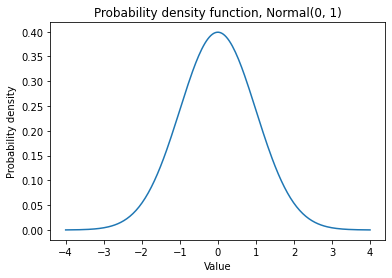

In [2]:
mu = 0.0
sigma = 1.0
x = np.linspace(-4, 4, 200)
y = sp.stats.norm.pdf(x, loc=mu, scale=sigma**2)
plt.plot(x,y)
plt.xlabel("Value")
plt.ylabel("Probability density")
_ = plt.title("Probability density function, Normal(0, 1)")

__Example__: a Binomial random variable characterised by its number of trials $n$ and probability of a success per trial $p$:
$$
Z \sim \mbox{Binomial}(n, p)
$$
with _probability mass function_
$$
f(z | n, p) = { n \choose z}p^z(1-p)^{n-z}
$$

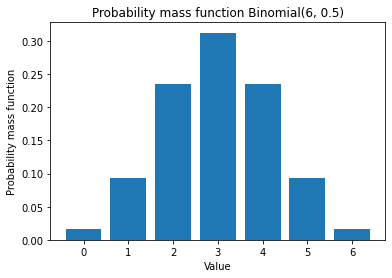

In [3]:
n = 15
p = 0.5
k = np.arange(7)
y = sp.stats.binom.pmf(k, n=6, p=0.5)
plt.bar(k, y)
plt.xlabel("Value")
plt.ylabel("Probability mass function")
_ = plt.title("Probability mass function Binomial(6, 0.5)")

As we'll see, we can compose random variables to develop much more complex data-generating processes...such as epidemic processes!

## An example in failure times

Suppose a computer components manufacturer is interested in measuring mean time to failure of a particular component.  They:

* Observe the time to failure of $n=100$ components, $y_1,\dots,y_n$
* Assume that the failure rate $\lambda$ is constant with respect to time

We'll simulate some data to work with, assuming a "true" failure rate $\lambda_0 = 0.1$, and plot a histogram.  To do this, we'll assume an Exponential($\lambda_0$) random variable describes our observed failure times (n.b. Exponential random variables model the time to failure when the failure rate is constant!)

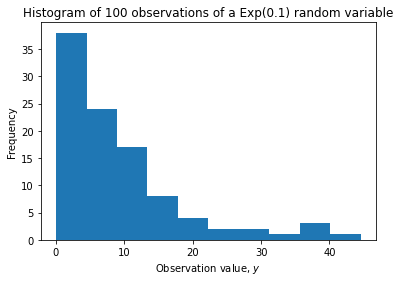

In [15]:
np.random.seed(0)
y = np.random.exponential(scale=1/0.1, size=100) # n.b. scipy using 1/rate
_ = plt.hist(y)
plt.xlabel(r"Observation value, $y$")
plt.ylabel("Frequency")
_ = plt.title("Histogram of 100 observations of a Exp(0.1) random variable")

Since each failure is an _independent_ event, the laws of probability tell us that the _joint probability density_ of observing all 100 values as we have is given by the _product_ of the probability densities for each event occurring. i.e. a product of Exponential probability density functions evaluated at each observed value
$$
Pr(y_1,\dots,y_n | \lambda) = \prod_{i=1}^{n} \lambda e^{-\lambda y_i}
$$

## The likelihood function

In the above example, we used the independence assumption between observations to construct a joint probability density function for observing $n=100$ failure times of computer components under the _assumption_ of a constant failure rate $\lambda$.  In statistical inference, we might be interested in estimating $\lambda$ in order to make predictions about the failure time of future components.

The likelihood function is simply this joint probability density function: it tells us the likelihood of observing our data given a particular failure rate $\lambda$ and the assumption of the Exponential model.  However, rather than viewing it as a function of the data $\mathbf{y}$ we view it as _a function of the parameter_, writing
$$
L(\lambda; y_1,\dots,y_n) \propto \prod_{i=1}^{n}\lambda e^{-\lambda y_i}.
$$

__Remarks__:

1. The likelihood function is _not_ a probability density function -- it does _not_ necessarily integrate to 1 as required by the axioms of probability, hence the proportionality sign $\propto$.
2. We don't really care about the absolute value of the likelihood function, but rather the _relative_ heights of the function for different values of the parameter(s) (here $\lambda$).

### Working with the log-likelihood

By the axioms of probability, each term in the likelihood product must be between 0 and 1.  In practice, this means that we end up with a possibly large product over quantities less than 1 leading to very small values of the likelihood function.  Despite often causing numerical rounding errors in computer software, there are good mathematical reasons for preferring to work with the (natural) logarithm of the likelihood function, i.e. 
$$
\ell(\lambda; y_1,\dots,y_n) = \log L(\lambda; y_1,\dots,y_n) = n \log \lambda - \lambda \sum_{i=1}^{n} y_i + c
$$
where $c$ is an additive constant.  Note that we don't really worry about $c$, and can cheerfully omit it, since all this does is shift the curve up and down the y-axis without altering the shape of the log-likelihood curve.

### The likelihood surface

As mentioned above, the log-likelihood function is viewed as a function of the _parameter_, keeping the data fixed.  This means we can plot the function over a range of $\lambda$s:

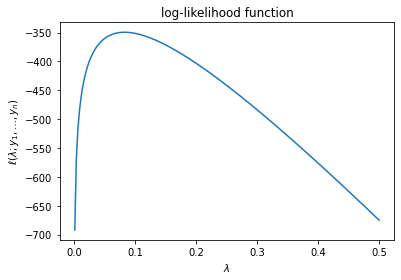

In [12]:
def log_likelihood(y, lam):  # n.b. `lambda` is a reserved keyword in Python
    return sp.stats.expon.logpdf(
        y, scale=1/lam
    ).sum()

lambda_vals = np.linspace(0.001, 0.5, 200)  
log_lik_vals = np.array([log_likelihood(y, l) for l in lambda_vals])
plt.plot(lambda_vals, log_lik_vals)
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$\ell(\lambda; y_1,\dots,y_n)$")
_ = plt.title("log-likelihood function")

### Exercise 1
Suppose we have _independent and identically-distributed_ observations 
where we assume $z_1,\dots,z_n \sim \mbox{Gamma}(\alpha, \beta)$.  Write down an expression for the log-likelihood function for $\alpha$ and $\beta$ having observed the data $\mathbf{z}$.

__Tip__: Consult Wikipedia for the probability density function of the Gamma distribution if you don't know it.

#### Solution

First write down the likelihood as a product of PDFs:
$$
L(\alpha, \beta; z_1,\dots,z_n) \propto \prod_{i=1}^{n} \frac{\beta^\alpha}{\Gamma(\alpha)} z_i^{\alpha - 1}e^{-\lambda z_i}
$$
and then take logs
$$
\ell(\alpha, \beta; z_1,\dots,z_n) = n \alpha \log \beta - n \log \Gamma(\alpha) + (\alpha - 1) \sum_{i=1}^{n} \log z_i - \lambda \sum_{i=1}^{n} z_i
$$

## Maximising the log-likelihood

Likelihood theory tells us that the best estimate of a parameter (or parameters) of interest corresponds to the maximum of the (log) likelihood.  For our exponential failure time model above, we have
$$
\hat{\lambda} = \underset{\lambda}{\mbox{argmax}}\,\ell(\lambda;y_1,\dots,y_n)
$$
where $\hat{\lambda}$ is said to be the _maximum likelihood estimate_ (MLE) of $\lambda$.  

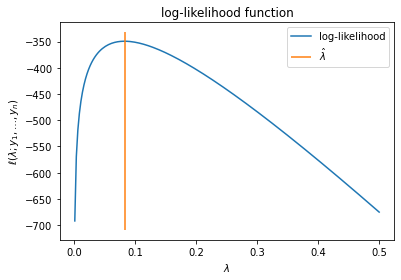

In [13]:
lambda_vals = np.linspace(0.001, 0.5, 200)  
log_lik_vals = np.array([log_likelihood(y, l) for l in lambda_vals])
plt.plot(lambda_vals, log_lik_vals, label=r"log-likelihood")
plt.vlines(1/np.mean(y), *plt.gca().get_ylim(), color="C1",label=r"$\hat{\lambda}$")
plt.legend()
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$\ell(\lambda; y_1,\dots,y_n)$")
_ = plt.title("log-likelihood function")

__NB__. Statisticians are interested in whether this estimate is unbiased with respect to some (hidden) "true" value of the parameter, i.e. $\hat{\lambda} = \lambda_0$, but that's another story!

### Numerical estimation

Eyeballing a graph like above can sometimes be sufficient for finding a quick and dirty maximum likelihood estimate.  The best way to find an MLE is to use calculus to find the value(s) of the parameter(s) that correspond to a gradient of 0, which occurs at the maximum, i.e. solve
$$
\frac{\mathrm{d}\ell(\lambda; z_1,\dots,\_n)}{\mathrm{d}\lambda} = 0
$$
for $\lambda$.

Often, though, this may be difficult to achieve.  As a halfway house, we can use numerical optimisation routines to find the maximum.  Note that most optimisation routines are configured to find the minimum of a function, so we can just negate the log likelihood.

In the following code example, we will compute the maximum likelihood estimate for the Exponential log-likelihood function for the failure times.  To do this, we will minimise the _negative_ of the log-likelihood (which is equivalent to maximising the log-likelihood) using the BFGS optimiser implemented in Scipy's `minimize` function.

In [16]:
from scipy.optimize import minimize

def opt_fn(lam): # Minimise the _negative_ of the log-likelihood
    return -log_likelihood(y, lam)

start_value = (0.1,)  # start the optimiser somewhere
lam_opt_results = minimize(
    opt_fn, x0=start_value, method="BFGS", options={"gtol": 1e-3}
)
lam_opt_results

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 321.77332877017665
        x: [ 1.089e-01]
      nit: 3
      jac: [-3.433e-05]
 hess_inv: [[ 1.186e-04]]
     nfev: 12
     njev: 6

The optimiser output shows `success: True` indicating it has reached (what it thinks is) the minimum of `opt_fn`.

It reports `x: [ 1.289e-01]` which is the value of the input parameter (i.e. $\lambda$) at the minimum.  We can check that this is the MLE, since for this simple example we happen to have the analytic solution:
$$
\hat{\lambda} = \frac{n}{\sum_{i=1}^{n} y_i}
$$

In [17]:
assert np.abs(lam_opt_results.x - y.shape[0]/sum(y)) < 1e-6  # All good!

### Computing standard errors

Likelihood theory tells us that the more data we have (i.e. as $n$ increases), the more "peaky" the (log) likelihood surface becomes.  In fact, it turns out that the standard error for the MLE is related to the curvature (i.e. the rate of change of the gradient of the curve) of the log-likelihood function at it maximum.

This concept is formalised as the Fisher Information, defined as
$$
\mathcal{I}(\lambda) = -E_{\lambda}\left[\frac{\partial ^2\ell(\hat{\lambda}; y_1,...,y_n)}{\partial\lambda^2} \right]
$$
which is the negative of the expected curvature (i.e. second derivative) of the log-likelihood function under random sampling.  It is a measure of the amount of information contained in the data $\mathbf{y}$ about the parameter (or parameters) $\lambda$.

The variance of $\hat{\lambda}$ under random sampling then turns out to be the inverse of the Fisher Information
$$
\mathrm{Var}(\hat{\lambda}) =\mathcal{I}(\hat{\lambda})^{-1}.
$$

If this seems horrendously complicated, it turns out that Python's `minimize` function does most of the work for us by providing the _inverse_ Hessian matrix (`hess_inv`), the Hessian matrix being the matrix of second-derivatives of the function of interest.  Since we have already negated our log-likelihood function, we get the negative in the expression for $\mathcal{I}(\lambda)$ for free, and Python has computed the inverse needed in the expression for $\mathrm{Var}(\hat{\lambda})$.  Indeed, the inverse Hessian matrix is the _covariance matrix_ for our estimates.

The standard error for each parameter is then the square-root of the _diagonal_ of the inverse Hessian matrix (here the diagonal is just the value of the single element in our $1 \times 1$ matrix):

In [18]:
sd_lam = np.sqrt(np.diag(lam_opt_results.hess_inv))
print("Standard error of lambda:", sd_lam)

Standard error of lambda: [0.01088992]


And _if_ we believe that the sampling distribution of $\hat{\lambda}$ is Normal (as the central limit theorem suggests it will be given enough data), we can compute simple (approximate!) Wald confidence intervals in the usual way:

In [19]:
lower_ci = lam_opt_results.x - 1.96 * sd_lam
upper_ci = lam_opt_results.x + 1.96 * sd_lam

print(f"lambda={lam_opt_results.x[0]:.3f} with approximate 95% confidence interval\
({lower_ci[0]:.3f},{upper_ci[0]:.3f})")

lambda=0.109 with approximate 95% confidence interval(0.088,0.130)


__Note__: these are approximate confidence intervals, and rely on the assumption that the sampling distribution of $\lambda$ is Normal.  Care should be taken when performing inference on small numbers of observations, as this assumption can easily fail!

### Exercise 2

For the Gamma-distribution in Example 1, and for observations

In [20]:
z = np.array([0.28026452, 0.79762029, 0.49992535, 1.40812533, 2.50872861,
       0.1812    , 0.72590275, 0.87779838, 0.60579613, 0.61161901])

plot a contour surface of the joint log-likelihood function for $\alpha, \beta \in [0.01, 4.0]$.

1. What do you notice about the contour plot?
2. What does it mean about $\alpha$ and $\beta$?
   
__Hint__: use the method described in the [Matplotlib `contour` demo](https://matplotlib.org/stable/gallery/images_contours_and_fields/contour_demo.html), and set the `levels` argument to `plt.contour` to about 20.

#### Solution

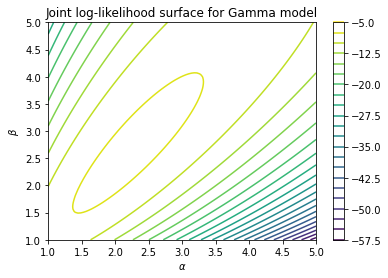

In [21]:
def loglik_gamma(z, alpha, beta):
    return sp.stats.gamma.logpdf(z, a=alpha, scale=1/beta).sum()

# Vectorize the log likelihood over alpha and beta
loglik_vfn = np.vectorize(lambda a, b: loglik_gamma(z, a, b))

# Create a grid over which to plot contours
alpha = np.linspace(1.0, 5.0, 100)
beta = np.linspace(1.0, 5.0, 100)
alpha_, beta_ = np.meshgrid(alpha, beta)
log_liks = loglik_vfn(alpha_, beta_)

# Plot the contours -- you can fiddle with the `levels` parameter
plt.contour(alpha_, beta_, log_liks, levels=20)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.title("Joint log-likelihood surface for Gamma model")
_ = plt.colorbar()

### Exercise 3

Take the Gamma-distribution model in Exercise 1 and the data in Exercise 2, and:

1. find the MLE for both $\alpha$ and $\beta$ using numerical optimisation.
2. look at the inverse Hessian matrix.  What do the off-diagonals represent, and are they consistent with the plot in Exercise 2?
3. Compute approximate standard errors for $\hat{\alpha}$ and $\hat{\beta}$.

### Solution

In [22]:
def gamma_opt_fn(par):
    return -sp.stats.gamma.logpdf(z, a=par[0], scale=1/par[1]).sum()

start_vals = [0.1, 0.1]
gamma_opt_results = minimize(gamma_opt_fn, start_vals, method="BFGS")

assert gamma_opt_results.success  # Make sure we converge

estimates = gamma_opt_results.x
print(f"Estimates:\n\talpha={estimates[0]:.2f}\n\tbeta={estimates[1]:.2f}")

Estimates:
	alpha=2.19
	beta=2.58


A quick look at the inverse Hessian matrix confirms the off-diagonals are positive and reasonably large, which confirms our suspicions given the strong diagonal axis in the contour plot in Exercise 2. 

In [23]:
gamma_opt_results.hess_inv

array([[0.81607655, 0.96013782],
       [0.96013782, 1.43312314]])

In [24]:
# Approximate 95% confidence intervals
stderr = np.sqrt(np.diag(gamma_opt_results.hess_inv))
lower_ci = estimates - 1.96 * stderr
upper_ci = estimates + 1.96 * stderr

for i, label in enumerate(["alpha", "beta"]):
    print(f"{label} = {estimates[i]:.2f} ({lower_ci[i]:.2f}, {upper_ci[i]:.2f})")

alpha = 2.19 (0.42, 3.96)
beta = 2.58 (0.23, 4.92)


..but we shouldn't put too much faith in these confidence intervals, as our contour plot shows that the likelihood surface is highly skewed indicating the sampling distribution for the estimates is likely to be too!

## Conditional probability

A Multinomial distribution can be used to assort $n$ objects into $d$ categories according to a $d$-dimensional vector of probabilities $p$:
$$
\mathbf{y} \sim \mbox{Multinomial}(n, \mathbf{p}).
$$

One way of constructing a draw from a Multinomial distribution is to sequentially draw from Binomial random variables according to the following function:

In [25]:
def draw_multinomial(n, p):
    p = np.array(p) # Ensure p is a numpy array
    
    if p.shape[0] == 1:  # Terminal condition
        return [n]
    
    p = p / p.sum() # re-normalise probabilities
    y = np.random.binomial(n, p[0])
    
    return [y] + draw_multinomial(n-y, p[1:]) # Concatenate list

For example:

In [26]:
draw_multinomial(100, [0.2, 0.3, 0.4, 0.1])

[22, 27, 39, 12]

Here, we have a series of Binomially-distributed random variables drawn one after another, and which depend on each other.  In other words, element 2 depends on element 1, element 3 depends on element 2, and so on.

How do we write down a likelihood function based on this data generating process?  Since we _observe_ the values of our multinomial draw, we can exploit the principle of _conditional independence_, where each successive Binomial draw is independent of the last _if and only if_ we know what the intervening values are.  Here, we have
$$
Pr(y_1, y_2, y_3, y_4) = Pr(y_1)Pr(y_2 | y_1)Pr(y_3 | y2)Pr(y_4 | y3)
$$

### Exercise 4

1. Using the principle of _conditional independence_, write down the joint likelihood for the above Multinomial drawing process following the above pattern. Look up the form of the Binomial distribution on Wikipedia if you need to.
2. Show that your expression is proportional to $$f(\mathbf{y}|\mathbf{p}) \propto p_1^{y_1}p_2^{y_2}p_3^{y_3}(1-p_1-p_2-p_3)^{n-y_1-y_2-y_3}$$.

## Concluding remarks

In this notebook, we have:

1. looked at writing down likelihood functions for a couple of different models, using independence (and identically-distributed) arguments to help us;  
2. found maximum likelihood estimates (MLEs) for the parameters of these models given data;
3. used the inverse Fisher Information matrix to compute approximate 95% confidence intervals for the parameter estimates;
4. considered how we can use the notion of conditional probability to write down a likelihood function, provided we observed all relevant data.

As a subject, Maximum Likelihood Estimation goes _much_ further than this primer to deal with cases where parameters are highly correlated, when data is not independent, and when Normally-distributed sampling distributions cannot be assumed.  A couple of good reference are:

* [Cassella and Berger "Statistical Inference", Second Edition, Duxbury Advanced Series, 2002.](https://mybiostats.wordpress.com/wp-content/uploads/2015/03/casella-berger.pdf)
* [Le Cam, Lucien (1990). "Maximum likelihood: An Introduction". ISI Review. __58__(2): 153–171](https://www.jstor.org/stable/1403464)